# Michał Filipiuk - 385423
## SAD assignment

### Imports

In [28]:
library(car)
library(caret)
library(purrr)
library(tidyr)
library(ggplot2)
library(reshape)
library(MASS)
library(Metrics)
library(lightgbm)
library(glmnet)
library(xgboost)
require(pls)

Loading required package: pls

Attaching package: ‘pls’

The following objects are masked from ‘package:analogue’:

    crossval, pcr, RMSEP

The following object is masked from ‘package:vegan’:

    scores

The following object is masked from ‘package:caret’:

    R2

The following object is masked from ‘package:stats’:

    loadings



### Loading data

#### Cancer data - regression

In [2]:
load("cancer.RData")
cancer.data.train <- data.train
cancer.data.test <- data.test

#### Protein - regression

In [3]:
load("protein.RData")
protein.data.train <- data.frame(data.train)
protein.data.test <- data.test

### Data preprocessing

To analyze which columns are categorical and which are numerical, I will count the percent of unique values for each variable. If number is smaller than 1%, I'll classify it as categorical.

Cancer

In [4]:
cancer.categorical.columns <- colnames(cancer.data.train)[sapply(cancer.data.train, function(x){return(length(unique(x))/nrow(cancer.data.train)*100 < 1)})]

In [5]:
length(cancer.categorical.columns) / ncol(cancer.data.train)

[1] 0

Protein

In [6]:
protein.categorical.columns <- colnames(protein.data.train)[sapply(protein.data.train, function(x){return(length(unique(x))/nrow(protein.data.train)*100 < 1)})]

In [7]:
protein.data.train[protein.categorical.columns]  <- lapply(protein.data.train[protein.categorical.columns] , factor)

In [8]:
for(c in protein.categorical.columns){
    levels(protein.data.train[,c]) <- c(0,1)
}

In [9]:
length(protein.categorical.columns) / ncol(protein.data.train)

[1] 0.5002499

As we see, cancer dataset has no categorical variables, while over a half from protein are categorical

In [10]:
sum(is.na(cancer.data.train))

[1] 0

In [11]:
sum(is.na(cancer.data.test))

[1] 0

In [12]:
sum(is.na(protein.data.train))

[1] 0

In [13]:
sum(is.na(protein.data.test))

[1] 0

Perfect! Our data has no missing values!

### Building model

In [14]:
CV = function(formula, model, data, number.of.folds = 5, Y="Y"){
    fold.cut <-sample(cut(1:(dim(data)[1]), breaks = number.of.folds, labels = FALSE))
    mse.list = vector()
    for(i in 1:number.of.folds){
        train.data <- data[-(fold.cut == i), ]
        test.data <- data[(fold.cut == i), ]
        trained.model <- model(formula, data = train.data)
        x <- predict(trained.model, newdata = test.data)
        mse.list[i] <- mse(test.data$Y, x)    
    }
    print(mean(mse.list))
}

#### Protein

##### Linear regression

Let's take a look at feature importance according to lasso

In [40]:
fit = glmnet(as.matrix(protein.data.train[, !names(protein.data.train) %in% c("Y")]), protein.data.train$Y, alpha = 1)

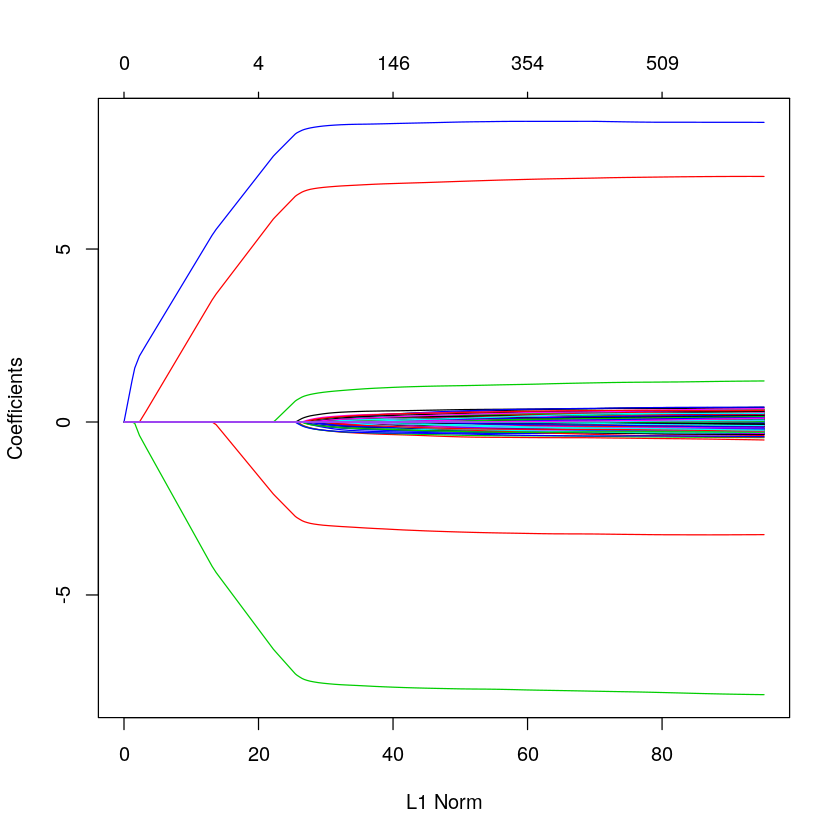

In [41]:
plot(fit)

So we have to take just 5 variables

In [33]:
tmp_coeffs <- coef(fit, s = fit$lambda[50])
data.frame(name = tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1], coefficient = tmp_coeffs@x)

name,coefficient
(Intercept),16.2474851
x1623,8.2088786
x1764,6.4046415
x1028,0.4937093
x420,-7.1493013
x456,-2.6098243


In [37]:
CV(Y ~ 1 + x1623 + x1764 + x1028 + x420 + x456, data = protein.data.train, model=lm)

[1] 36.72422


In [145]:
model.protein.lm = lm(Y ~ 1 + x1623 + x1764 + x1028 + x420 + x456, data = protein.data.train,)

In [147]:
best.features.protein <- c("x1623","x1764","x1028","x420","x456")

##### XGBoost
Let's try now something different

In [115]:
model <- train(
  Y ~., data = protein.data.train[,c(best.features.protein,"Y")], method = "xgbTree",
  trControl = trainControl("cv", number = 10)
  )

In [135]:
dtrain <- xgb.DMatrix(data.matrix(protein.data.train[,best.features.protein]), label = protein.data.train[,"Y"])
cv <- xgb.cv(data = dtrain, nrounds = 100, nthread = 4, nfold = 5, metrics = list("rmse"),
                  max_depth = 4, eta = 0.2, lambda = 2, alpha=1, objective = "reg:linear")

[1]	train-rmse:18.794322+0.168125	test-rmse:18.989687+0.803819 
[2]	train-rmse:16.066806+0.120374	test-rmse:16.505774+0.684960 
[3]	train-rmse:13.907464+0.102198	test-rmse:14.654388+0.703796 
[4]	train-rmse:12.234256+0.116238	test-rmse:13.270582+0.704556 
[5]	train-rmse:10.914498+0.123643	test-rmse:12.237051+0.765119 
[6]	train-rmse:9.872320+0.130451	test-rmse:11.435853+0.871409 
[7]	train-rmse:9.044730+0.143736	test-rmse:10.851854+0.976836 
[8]	train-rmse:8.337310+0.136046	test-rmse:10.335507+1.113273 
[9]	train-rmse:7.783666+0.134492	test-rmse:9.930953+1.207358 
[10]	train-rmse:7.330367+0.109192	test-rmse:9.572031+1.282955 
[11]	train-rmse:6.947243+0.097803	test-rmse:9.237925+1.286784 
[12]	train-rmse:6.630570+0.077457	test-rmse:9.037792+1.243497 
[13]	train-rmse:6.350575+0.073733	test-rmse:8.788430+1.245075 
[14]	train-rmse:6.130731+0.054878	test-rmse:8.594039+1.233636 
[15]	train-rmse:5.935820+0.043261	test-rmse:8.493125+1.276142 
[16]	train-rmse:5.768157+0.054281	test-rmse:8.38266

As we see, XGBoost may performs well on train data, but overfits fatally on test set 

#### Cancer data

##### Linear regression with lasso

In [32]:
fit = cv.glmnet(data.matrix(cancer.data.train[, !names(cancer.data.train) %in% c("Y")]), cancer.data.train$Y, alpha = 1)

In [33]:
small.lambda.index <- which(fit$lambda == fit$lambda.min)

In [34]:
tmp_coeffs <- coef(fit, s = fit$lambda[small.lambda.index])
selected.features <- tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1][-1]

In [37]:
selected.features

[1] "ENSG00000001561" "ENSG00000005381" "ENSG00000010803" "ENSG00000021355"
  [5] "ENSG00000027001" "ENSG00000039319" "ENSG00000049089" "ENSG00000055208"
  [9] "ENSG00000065923" "ENSG00000087253" "ENSG00000088280" "ENSG00000090382"
 [13] "ENSG00000090661" "ENSG00000091947" "ENSG00000095637" "ENSG00000096070"
 [17] "ENSG00000100442" "ENSG00000100532" "ENSG00000100867" "ENSG00000102287"
 [21] "ENSG00000102471" "ENSG00000102572" "ENSG00000102805" "ENSG00000105205"
 [25] "ENSG00000105472" "ENSG00000107819" "ENSG00000108774" "ENSG00000109133"
 [29] "ENSG00000109787" "ENSG00000109929" "ENSG00000110455" "ENSG00000111832"
 [33] "ENSG00000111875" "ENSG00000112640" "ENSG00000113360" "ENSG00000113456"
 [37] "ENSG00000113845" "ENSG00000114554" "ENSG00000114982" "ENSG00000115828"
 [41] "ENSG00000115841" "ENSG00000115970" "ENSG00000117461" "ENSG00000118113"
 [45] "ENSG00000120318" "ENSG00000124486" "ENSG00000124882" "ENSG00000125735"
 [49] "ENSG00000127515" "ENSG00000129911" "ENSG00000130234" "ENSG00000132334"
 [53] "ENSG00000133256" "ENSG00000135838" "ENSG00000136158" "ENSG00000137090"
 [57] "ENSG00000137198" "ENSG00000140522" "ENSG00000144893" "ENSG00000145040"
 [61] "ENSG00000148180" "ENSG00000148795" "ENSG00000150656" "ENSG00000150712"
 [65] "ENSG00000154330" "ENSG00000155754" "ENSG00000156140" "ENSG00000158163"
 [69] "ENSG00000158825" "ENSG00000159445" "ENSG00000159685" "ENSG00000161091"
 [73] "ENSG00000161544" "ENSG00000163216" "ENSG00000163217" "ENSG00000163393"
 [77] "ENSG00000165113" "ENSG00000165131" "ENSG00000165152" "ENSG00000165621"
 [81] "ENSG00000165868" "ENSG00000166321" "ENSG00000166823" "ENSG00000167617"
 [85] "ENSG00000170373" "ENSG00000170950" "ENSG00000170961" "ENSG00000172146"
 [89] "ENSG00000172244" "ENSG00000173110" "ENSG00000175711" "ENSG00000175832"
 [93] "ENSG00000175874" "ENSG00000176076" "ENSG00000178795" "ENSG00000179979"
 [97] "ENSG00000180871" "ENSG00000181381" "ENSG00000181467" "ENSG00000182950"
[101] "ENSG00000183674" "ENSG00000184232" "ENSG00000186088" "ENSG00000186117"
[105] "ENSG00000186204" "ENSG00000186889" "ENSG00000187446" "ENSG00000187601"
[109] "ENSG00000187672" "ENSG00000188171" "ENSG00000196131" "ENSG00000198183"
[113] "ENSG00000198626" "ENSG00000198838" "ENSG00000205444" "ENSG00000213066"
[117] "ENSG00000214711" "ENSG00000215529" "ENSG00000225595" "ENSG00000237110"
[121] "ENSG00000242852" "ENSG00000244405" "ENSG00000248905" "ENSG00000258227"

In [42]:
CV(paste("Y ~ 1 + ",paste(selected.features, collapse="+"),sep = ""), data =  cancer.data.train, model=lm)

[1] 0.007093362


In [88]:
model <- lm(paste("Y ~ 1 + ",paste(selected.features, collapse="+"),sep = ""), data =  cancer.data.train)

In [89]:
summary(model)


Call:
lm(formula = paste("Y ~ 1 + ", paste(selected.features, collapse = "+"), 
    sep = ""), data = cancer.data.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38045 -0.05491  0.00658  0.05629  0.20580 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.034e+00  4.485e-01   2.305 0.021598 *  
ENSG00000001561  1.696e-05  5.448e-03   0.003 0.997517    
ENSG00000005381 -1.894e-02  6.716e-03  -2.820 0.005015 ** 
ENSG00000010803  1.578e-02  9.719e-03   1.624 0.105102    
ENSG00000021355 -3.552e-03  2.640e-03  -1.345 0.179154    
ENSG00000027001  4.809e-04  6.094e-03   0.079 0.937141    
ENSG00000039319 -1.136e-02  1.344e-02  -0.845 0.398648    
ENSG00000049089  1.745e-02  2.190e-02   0.797 0.426052    
ENSG00000055208  8.975e-03  9.697e-03   0.925 0.355194    
ENSG00000065923  3.010e-03  7.651e-03   0.393 0.694215    
ENSG00000087253  8.518e-03  4.433e-03   1.922 0.055270 .  
ENSG00000088280  1.427e-02  6.380e-03   2.237 0.025

In [139]:
model <- lm(paste("Y ~ 1 + ",paste(selected.features[(summary(model)$coefficients[,4] < 0.75)[-1]], collapse="+"),sep = ""), data =  cancer.data.train)

In [143]:
CV(paste("Y ~ 1 + ",paste(selected.features[(summary(model)$coefficients[,4] < 0.75)[-1]], collapse="+"),sep = ""), data =  cancer.data.train, model=lm)

[1] 0.007776233


##### PCR with linear regression

In [150]:
pcr_model <- pcr(Y~., data = cancer.data.train[,c(selected.features,'Y')], scale = TRUE, validation = "CV") # I'm forced to take only a subset of variables because of stack overflow

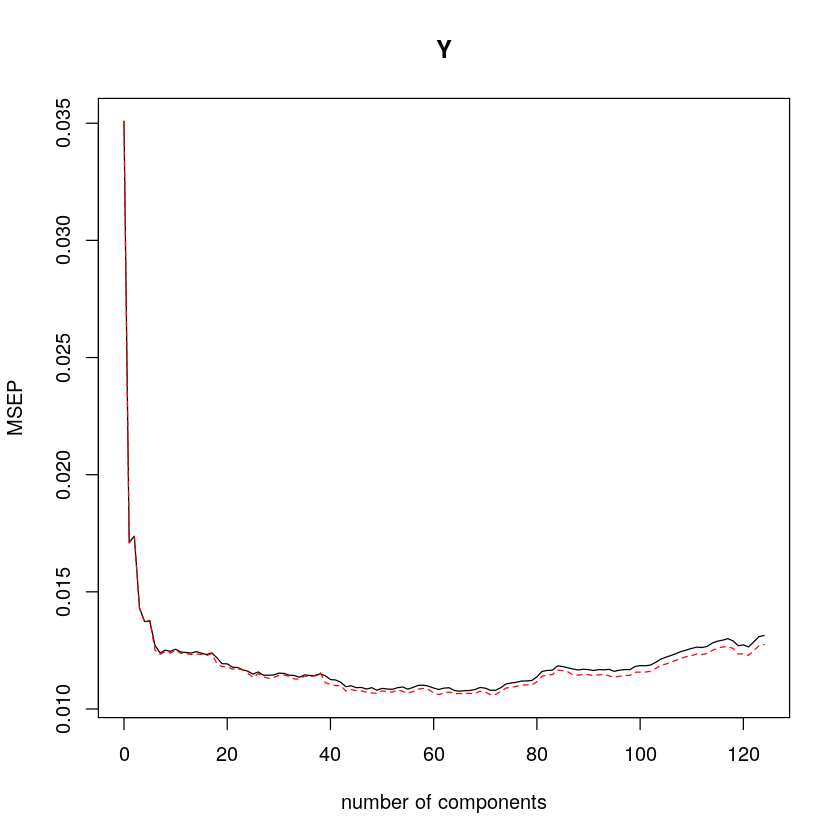

In [156]:
validationplot(pcr_model, val.type="MSEP")

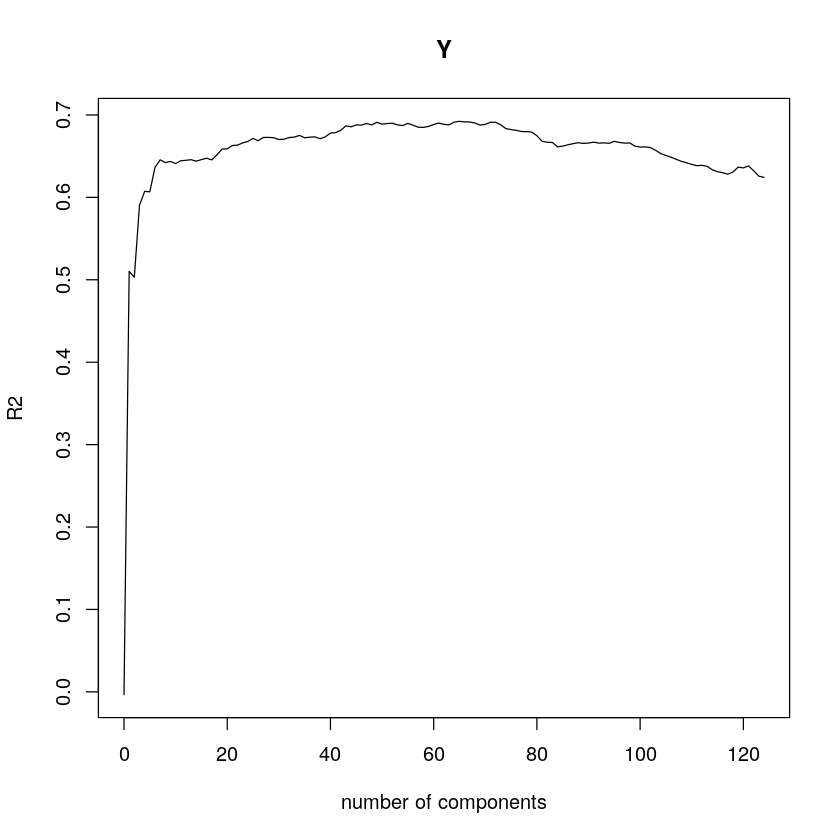

In [157]:
validationplot(pcr_model, val.type = "R2")

##### XGBoost

In [210]:
dtrain <- xgb.DMatrix(data.matrix(cancer.data.train[, !names(cancer.data.train) %in% c("Y")]), label = cancer.data.train[,"Y"])
x <- xgb.importance(model = xgboost(data = dtrain, nrounds = 100, nthread = 4, nfold = 5, metrics = list("rmse"),
                  max_depth = 5, eta = 0.2, lambda = 2, alpha=1, objective = "reg:linear"))

[1]	train-rmse:0.296343 
[2]	train-rmse:0.247918 
[3]	train-rmse:0.209511 
[4]	train-rmse:0.178922 
[5]	train-rmse:0.153549 
[6]	train-rmse:0.134065 
[7]	train-rmse:0.117401 
[8]	train-rmse:0.104807 
[9]	train-rmse:0.093778 
[10]	train-rmse:0.085120 
[11]	train-rmse:0.078758 
[12]	train-rmse:0.072711 
[13]	train-rmse:0.068180 
[14]	train-rmse:0.064158 
[15]	train-rmse:0.060501 
[16]	train-rmse:0.057103 
[17]	train-rmse:0.054107 
[18]	train-rmse:0.051496 
[19]	train-rmse:0.048939 
[20]	train-rmse:0.046724 
[21]	train-rmse:0.044850 
[22]	train-rmse:0.042987 
[23]	train-rmse:0.041353 
[24]	train-rmse:0.040044 
[25]	train-rmse:0.038507 
[26]	train-rmse:0.037220 
[27]	train-rmse:0.036082 
[28]	train-rmse:0.034912 
[29]	train-rmse:0.033821 
[30]	train-rmse:0.032815 
[31]	train-rmse:0.031896 
[32]	train-rmse:0.031080 
[33]	train-rmse:0.030207 
[34]	train-rmse:0.029579 
[35]	train-rmse:0.028747 
[36]	train-rmse:0.028138 
[37]	train-rmse:0.027528 
[38]	train-rmse:0.026901 
[39]	train-rmse:0.026

In [254]:
selected.features.for.xgboost <- x[order(Gain, decreasing = T),] [1:100,]$Feature

In [255]:
dtrain <- xgb.DMatrix(data.matrix(cancer.data.train[, selected.features.for.xgboost]), label = cancer.data.train[,"Y"])
cv <- xgb.cv(data = dtrain, nrounds = 100, nthread = 4, nfold = 5, metrics = list("rmse"),
                  max_depth = 4, eta = 0.2, lambda = 2, alpha=1, objective = "reg:linear", gamma=0.1)

[1]	train-rmse:0.298051+0.001427	test-rmse:0.300488+0.003860 
[2]	train-rmse:0.251528+0.001122	test-rmse:0.256936+0.003419 
[3]	train-rmse:0.215179+0.001278	test-rmse:0.224354+0.001833 
[4]	train-rmse:0.186192+0.001257	test-rmse:0.200348+0.002044 
[5]	train-rmse:0.163231+0.001184	test-rmse:0.181171+0.002494 
[6]	train-rmse:0.145488+0.001099	test-rmse:0.167550+0.003796 
[7]	train-rmse:0.131422+0.000967	test-rmse:0.156686+0.004998 
[8]	train-rmse:0.121076+0.001445	test-rmse:0.149131+0.005965 
[9]	train-rmse:0.113132+0.000954	test-rmse:0.144210+0.006954 
[10]	train-rmse:0.106733+0.001312	test-rmse:0.139631+0.007505 
[11]	train-rmse:0.102462+0.001401	test-rmse:0.136921+0.008293 
[12]	train-rmse:0.099286+0.001358	test-rmse:0.135235+0.008694 
[13]	train-rmse:0.096621+0.001443	test-rmse:0.133618+0.008705 
[14]	train-rmse:0.094703+0.001518	test-rmse:0.132331+0.008804 
[15]	train-rmse:0.093135+0.000924	test-rmse:0.131674+0.009196 
[16]	train-rmse:0.092364+0.001350	test-rmse:0.131273+0.009387 
[

### Analyzing most important variables

#### Protein

##### Vif

#### Cancer

##### Vif

### Saving data